# General imports

In [47]:
%load_ext autoreload

import numpy
from os import listdir,path
import pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading images and creating vectors

In [ ]:
categories = [
    "A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z",
    "del","nothing","space"
]
cat_to_label = {cat:i for i,cat in enumerate(categories)}
label_to_cat = {i:cat for i,cat in enumerate(categories)}

In [ ]:
training_folder = "../Datasets/ASL/asl_alphabet_train/"

training_images = []
training_labels = []
testing_images = []
testing_labels = []

for cat in categories:
    label = cat_to_label[cat]
    files = listdir(training_folder+cat+"/")
    
    # We keep 1% for testing, 99% for training.
    num_files = len(files)
    num_training_files = int(numpy.ceil(num_files * 0.99))
    training_files = files[:num_training_files]
    testing_files = files[num_training_files:]
    
    training_images += [path.abspath(training_folder+cat+"/"+f) for f in training_files]
    training_labels += [label for f in training_files]
    
    testing_images += [path.abspath(training_folder+cat+"/"+f) for f in testing_files]
    testing_labels += [label for f in testing_files]
    
print("Number of training files in total : "+str(len(training_images)))
print("Number of testing files in total : "+str(len(testing_images)))

In [ ]:
%autoreload 2
import data_processing as DP

DP.write_image_vectors_to_file(training_images, 32, training_labels, "../Datasets/ASL/train.npy")
DP.write_image_vectors_to_file(testing_images, 32, testing_labels, "../Datasets/ASL/test.npy")

# Loading vectors and creating training and testing sets

In [10]:
training_examples = numpy.load("../Datasets/ASL/train.npy")
print(training_examples.shape)

testing_examples = numpy.load("../Datasets/ASL/test.npy")
print(testing_examples.shape)

(1025, 86130)
(1025, 870)


In [20]:
# Shuffling examples 
numpy.random.seed(42)
training_perm = numpy.random.permutation(training_examples.shape[1])
shuffled_training_examples = training_examples[:, training_perm][:,:10000]
print("Examples shuffled : "+str(shuffled_training_examples.shape))

Examples shuffled : (1025, 10000)


In [23]:
# We normalize the data.
X_train = shuffled_training_examples[1:,:] / 255 
print("X_train : "+str(X_train.shape))
Y_train = shuffled_training_examples[:1, :]
print("Y_train : "+str(Y_train.shape))

X_test = testing_examples[1:,:] / 255 
print("X_test : "+str(X_test.shape))
Y_test = testing_examples[:1, :]
print("Y_test : "+str(Y_test.shape))

# Classifying A or not A (class 0)
train_labels = (Y_train == 0) * 1
print("Training set : ")
print("\tNumber of positive examples : "+str(numpy.sum(train_labels)))
print("\tNumber of negative examples : "+str(numpy.sum(1-train_labels)))

test_labels = (Y_test==0) *1
print("Testing set : ")
print("\tNumber of positive examples : "+str(numpy.sum(test_labels)))
print("\tNumber of negative examples : "+str(numpy.sum(1-test_labels)))

X_train : (1024, 10000)
Y_train : (1, 10000)
X_test : (1024, 870)
Y_test : (1, 870)
Training set : 
	Number of positive examples : 335
	Number of negative examples : 9665
Testing set : 
	Number of positive examples : 30
	Number of negative examples : 840


# Training the model

In [24]:
%autoreload 2
import classification as CL

num_features = X_train.shape[0]
num_examples = X_train.shape[1]

# Hyperparameters :
n_l = [num_features, 25, 25, 25, 25 ,1]

# Training model 
parameters, costs = CL.nn_model(
    X_train, train_labels, n_l, initialization="xavier", learning_rate=0.002, num_iterations=10000, print_cost=True
)

Cost after iteration 1: 0.843737
Cost after iteration 1001: 0.146820
Cost after iteration 2001: 0.144739
Cost after iteration 3001: 0.142972
Cost after iteration 4001: 0.140336
Cost after iteration 5001: 0.136585
Cost after iteration 6001: 0.132676
Cost after iteration 7001: 0.128978
Cost after iteration 8001: 0.125368
Cost after iteration 9001: 0.121977
Cost after all iterations : 0.11877417881814967



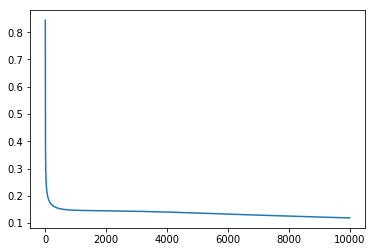

In [25]:
import matplotlib.pyplot as plt
plt.plot(costs)

## Evaluating model performance

### On the training set

In [55]:
%autoreload 2
import classification as CL

predictions, A_L = CL.predict(parameters, X_train, len(n_l)-1) * 1
score_details,f1_score = CL.compute_f1_score(predictions, train_labels)

df = pandas.DataFrame.from_dict(score_details).reindex(["labels", "predictions", "true_predictions", "false_predictions"])
display(HTML(df.to_html()))

df2 = pandas.DataFrame.from_dict(f1_score, orient='index', columns=["Global"])
display(HTML(df2.to_html()))

,positive,negative
labels,335,9665
predictions,13,9987
true_predictions,12,9664
false_predictions,1,323


,Global
precision,0.923077
recall,0.035821
f1_score,0.068966


### On testing set

In [ ]:
%autoreload 2
import classification as CL

predictions, A_L = CL.predict(parameters, X_test, len(n_l)-1) * 1
print("Same : \t\t"+str(numpy.sum(predictions == test_labels))+"\n")

cost = CL.compute_cost(A_L, test_labels, parameters)
print("Cost on the testing dataset : "+str(cost)+"\n\n")

score_details,f1_score = CL.compute_f1_score(predictions, test_labels)

df = pandas.DataFrame.from_dict(score_details).reindex(["labels", "predictions", "true_predictions", "false_predictions"])
display(HTML(df.to_html()))

df2 = pandas.DataFrame.from_dict(f1_score, orient='index', columns=["Global"])
display(HTML(df2.to_html()))